## COVID-19 Exercise

In this exercise you will explore using digital traces to detect outbreaks of COVID-19 in the state of Washington. There are many ways to define an outbreak, but for this task you will use a relatively simple definition: exponential growth of COVID-19 cases sustained over a number of weeks. First, download the CSV file for the exercise: covid_traces_WA.csv. The first non-date column represents File display und truth we will use to define outbreak occurrences (positive test counts). The remaining columns are various digital traces we will use for outbreak detection: upToDate search intensity, CDC reported ILI, Twitter related tweets, Google searches for 'fever', and Kinsa fever reporting. For ease of demonstration, the data has already undergone some preprocessing, which includes smoothing, which is why you will see fractional case counts.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [5]:
df = pd.read_csv('./data/covid_traces_WA.csv')
df['date'] = pd.to_datetime(df['date'])
display(df.head())

/var/folders/s6/rb08md7x7c1ff4ccqw8yxj940000gn/T/ipykernel_65954/1479641253.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


,date,new_cases,upToDate,Cuebiq_Mobility,Kinsa_AnomalousFeverAbsolute,cdc_ili,Twitter_RelatedTweets,google_fever
0,2020-01-01,0.0,0.0,3.452807,0.0,0.0,0.0,0.0
1,2020-01-02,0.0,0.0,3.861363,0.0,0.0,0.0,0.0
2,2020-01-03,0.0,0.0,3.896318,0.0,0.0,0.0,0.0
3,2020-01-04,0.0,0.0,3.753271,0.0,0.0,0.0,0.0
4,2020-01-05,0.0,0.0,3.501031,0.0,0.0,0.0,0.0


a) First, in a 6-panel plot, show the case counts and the five other digital traces over time. First focus on the case count curve. Intuitively, where would you decide are starts of outbreaks?
Then compare with the other digital traces. (Due to data limitations, only a small segment of the digital traces are available.) Do any of them show "outbreak" behavior? Are they lagging or leading indicators compared to the COVID-19 case counts?

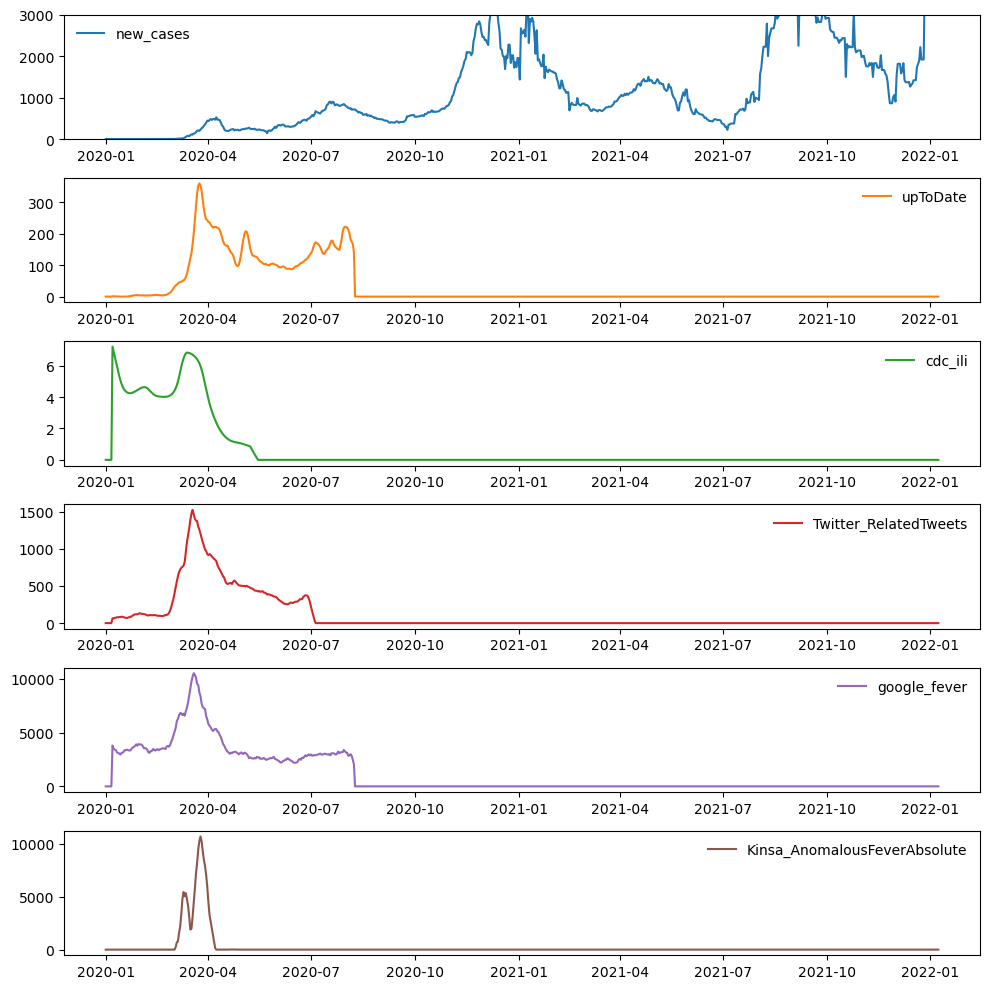

In [7]:
signals = ['new_cases', 'upToDate', 'cdc_ili',
           'Twitter_RelatedTweets', 'google_fever',
           'Kinsa_AnomalousFeverAbsolute']


fig_a, ax = plt.subplots(len(signals), 1)
fig_a.set_size_inches(10, 10)
for i, feat in enumerate(signals):
    ax[i].plot(df['date'], df[feat], label=feat, c=f'C{i}')
    ax[i].legend(frameon=False)
    
ax[0].set_ylim([0, 3000])
plt.tight_layout()
plt.show()

b) Now you will work on defining an outbreak mathematically. First, take a sliding window of 11 days over the case counts. In each window, fit a linear regression using the case counts on days 1–10 to predict the case counts on days 2–11. The regression should *not* include an intercept. Collect the slope of this regression $\alpha_i$ in a vector the same length as the original data. This will give you a vector of slopes $\alpha$ for each day in the dataset (the first 10 or so will be 0, which is fine).


In [8]:
alphas = {}
# repeat inner code over each signal
for signal in signals:
    # array to store alpha output, one entry for each day
    alpha_arr = np.zeros(len(df))
    xarr = df[signal].values
    for i in range(10, len(df)):
        # predictor is first 10 days
        before = xarr[i-10:i]
        # target is days 2-11
        after = xarr[i-9:i+1]
        lr = LinearRegression(fit_intercept=False)
        lr.fit(before.reshape(-1, 1), after)
        
        # get coefficient and store
        alpha = lr.coef_[0]
        alpha_arr[i] = alpha
    
    alphas[signal] = alpha_arr

c) Make a three-panel plot containing (i) the case count curve over time, (2) $\alpha$ over time, and (3) a binary variable indicating if $\alpha_i > 1$ over time. Interpret the meaning of $\alpha$.


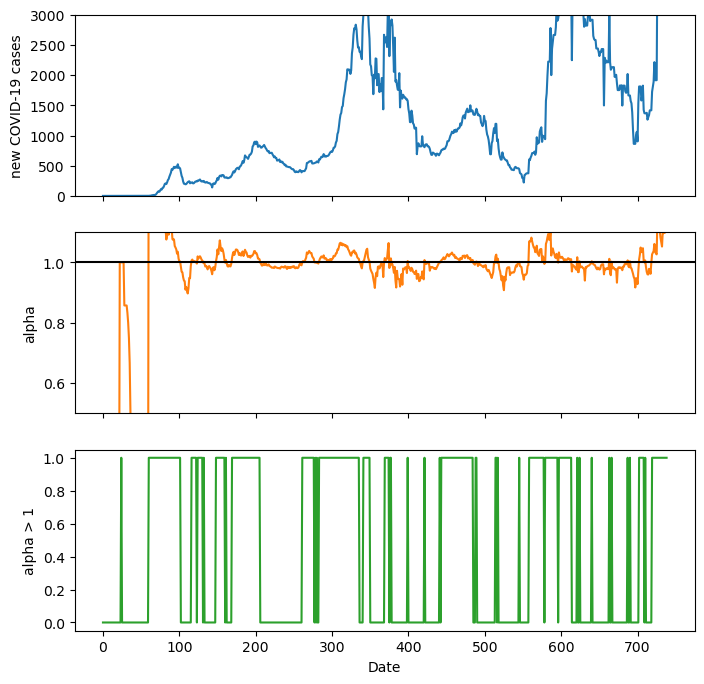

In [10]:
fig_c, ax = plt.subplots(3, sharex=True)
fig_c.set_size_inches(8, 8)
ax[0].plot(range(len(alphas['new_cases'])), df['new_cases'], label='cases')
ax[1].plot(range(len(alphas['new_cases'])), alphas['new_cases'], label='cases', c='C1')
ax[2].plot(
    range(len(alphas['new_cases'])), (alphas['new_cases'] > 1).astype(int),
    label='cases', c='C2')

ax[1].axhline(1, c='k')
ax[0].set_ylabel('new COVID-19 cases')
ax[0].set_ylim([0, 3000])
ax[1].set_ylim([0.5, 1.1])
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('alpha > 1')
ax[2].set_xlabel('Date')
plt.show()


d) Next, you will step through an outbreak detection algorithm. Whenever $\alpha_i > 1$ for 10 days in a row (sustained case growth), we detect an outbreak event as being active starting on the 10th day. However, we only want to record the *start* of the outbreak, so we only record the first time such a consecutive event occurs (so even if there are 15 days of sustained growth, only the 10th day is marked). Then once there are 10 consecutive days without growth ($\alpha_i < 1$), we define the outbreak to be over. Once an outbreak is over, the next time there are 10 consecutive days of growth, we record a *new* outbreak as active. Implement such a detection system and apply it to the case count time series.


In [12]:
outbreaks = {}

# repeat the inner detection code for each signal
for signal in signals:
    # array to store detection output, one entry for each day
    out_arr = np.zeros(len(df))
    
    # we only want to mark the *start* of an outbreak, so if an outbreak is already
    # occurring, we don't mark it
    outbreak_already_active = False
    alpha_arr = alphas[signal]
    for i in range(9, len(df)):
        outbreak = 0
        # check for sustained growth over last 10 days
        if np.sum(alpha_arr[i-9:i+1] > 1) == 10:
            # if outbreak already happening, don't mark it
            if outbreak_already_active:
                outbreak = 0
            # if start of outbreak, mark it, but also mark an outbreak as active
            else:
                outbreak_already_active = True
                outbreak = 1
        # if sustained non-growth over 10 days, then end the outbreak
        elif np.sum(alpha_arr[i-9:i+1] > 1) == 0:
            outbreak_already_active = False
        out_arr[i] = outbreak    
    outbreaks[signal] = out_arr

e) Regenerate the three-panel case count plot from (c), but now use markers to indicate the starts of outbreaks. Do these locations match your intuition of when outbreaks are starting?


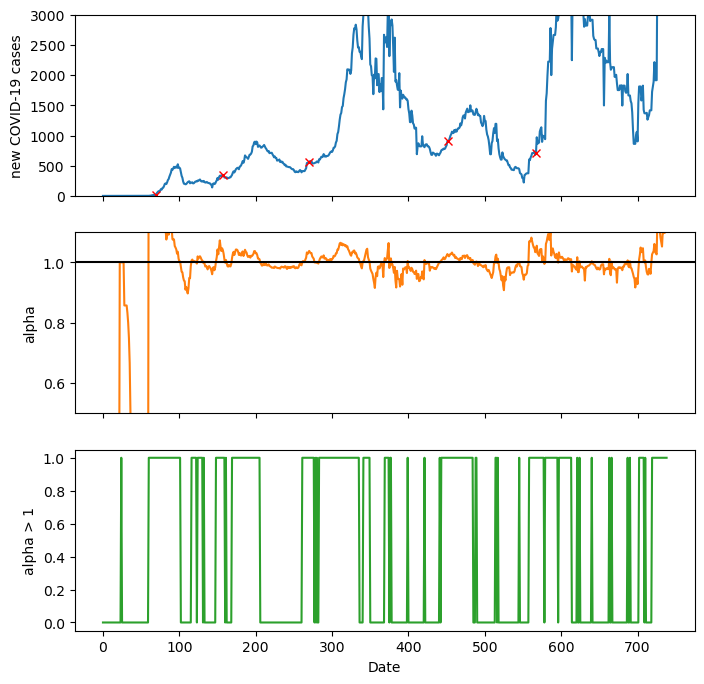

In [17]:
outbreak_locs = {}
# for each signal, record the time indices where outbreaks start
for signal in signals:
    loc = np.where(outbreaks[signal] == 1)[0]
    outbreak_locs[signal] = loc

fig_e, ax = plt.subplots(3, sharex=True)
fig_e.set_size_inches(8, 8)
ax[0].plot(range(len(alphas['new_cases'])), df['new_cases'], label='cases')
ax[1].plot(range(len(alphas['new_cases'])), alphas['new_cases'], label='cases', c='C1')
ax[2].plot(
    range(len(alphas['new_cases'])), (alphas['new_cases'] > 1).astype(int),
    label='cases', c='C2')

ax[1].axhline(1, c='k')
ax[0].set_ylabel('new COVID-19 cases')
ax[0].set_ylim([0, 3000])
ax[1].set_ylim([0.5, 1.1])
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('alpha > 1')
ax[2].set_xlabel('Date')

# add markers for outbreak locations
for t in outbreak_locs['new_cases']:
    ax[0].plot(t, df['new_cases'][t], c='r', marker='x')

plt.show()

f) Finally, repeat steps (b)–(e) for each of the other 5 digital traces. Make the six-panel plot from part (a) again but mark the outbreak locations as in (e). The idea is that if a sufficient number of traces show an outbreak ahead of the case counts, we can predict an imminent outbreak.

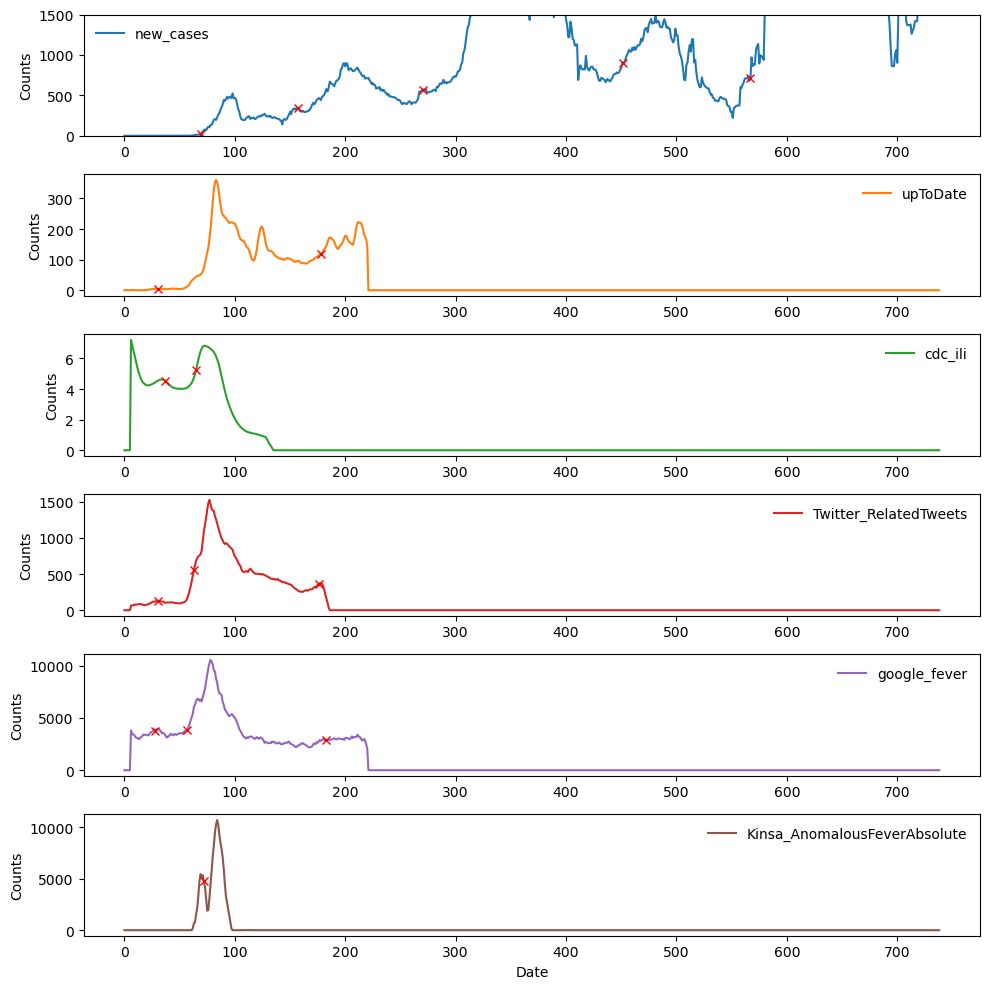

In [20]:
fig_f, ax = plt.subplots(len(signals), 1)
fig_f.set_size_inches(10, 10)
for i, feat in enumerate(signals):
    ax[i].plot(range(len(alphas['new_cases'])), df[feat],
               label=feat, c=f'C{i}')
    
    for t in outbreak_locs[feat]:
        ax[i].plot(t, df[feat][t], c='r', marker='x')

    ax[i].legend(frameon=False)
    ax[i].set_ylabel('Counts')

ax[0].set_ylim([0, 1500])

ax[5].set_xlabel('Date')
plt.tight_layout()
plt.show()